In [1]:
execfile(r'D:\measuring\analysis\scripts\setup_analysis.py')
from analysis.lib.m2.ssro import ssro, sequence
import scipy.fftpack
import scipy.signal
import win32com.client #imports the pywin32 library

%matplotlib inline

reloaded


In [ ]:
def read_data():
    folder = tb.latest_data('mw_pulse_msmt')
    f = sequence.SequenceAnalysis(folder, hdf5_mode='r') 
    waveform = np.array(f.g['oscilloscope_msmt']['data'])
    global number_of_pulses
    number_of_pulses = int(np.array(f.g['oscilloscope_msmt']['number_of_pulses']))
    points_per_pulse = 1e6 // number_of_pulses
    t = np.zeros((number_of_pulses, points_per_pulse))
    amplitude = np.zeros((number_of_pulses, points_per_pulse))
    for i in range(number_of_pulses):
        t[i] = waveform[0][i*points_per_pulse:(i+1)*points_per_pulse]
        amplitude[i] = waveform[1][i*points_per_pulse:(i+1)*points_per_pulse]    
    return t, amplitude

def fourier(signal, time):
    t_step = (time[0][-1] - time[0][0])/time[0].size
    fft = scipy.fftpack.fft(signal)/signal.size
    freq = scipy.fftpack.fftfreq(time.size, t_step)
    n = len(fft)
    fft = fft[0:n/2]
    freq = freq[0:n/2]
    return np.abs(fft), freq

# Noise analysis

In [41]:
t, amplitude = read_data()

std_measurement_noise = np.std(amplitude)

print 'Standard deviation of the noise is {:.3e}'.format(std_measurement_noise)

Standard deviation of the noise is 6.773e-03


C:\Canopy\User\lib\site-packages\ipykernel\__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Canopy\User\lib\site-packages\ipykernel\__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Canopy\User\lib\site-packages\ipykernel\__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Canopy\User\lib\site-packages\ipykernel\__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


C:\Canopy\User\lib\site-packages\ipykernel\__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Canopy\User\lib\site-packages\ipykernel\__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Canopy\User\lib\site-packages\ipykernel\__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Canopy\User\lib\site-packages\ipykernel\__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


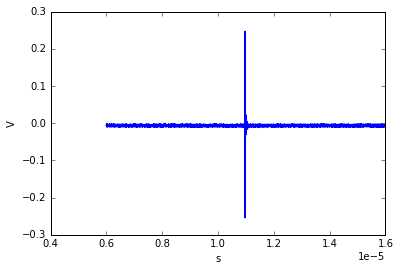

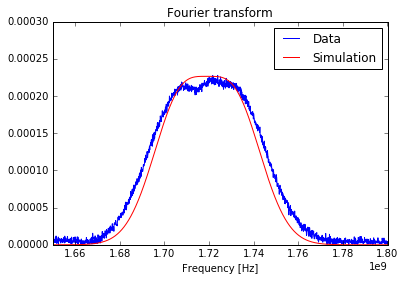

In [40]:
t, amplitude = read_data()
t = t[0]
amplitude = amplitude[0]
# Plot waveform
plt.plot(t, amplitude)
plt.xlabel('s')
plt.ylabel('V')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

# Fourier transform
fft, freq = fourier(amplitude, t)

# Plot the fourier transform
plt.plot(freq, fft, label='Data')
plt.title('Fourier transform')
plt.xlabel('Frequency [Hz]')
plt.xlim(1.65e9, 1.8e9)
plt.ylim(0, .0003)

# SIMULATION
# calculate Hermite pulse
env_amplitude = 2.3e-1
mu = 1e-5
T_herm = 1.667e-8
freq_sim = 1.719219e9
env = env_amplitude*(1-0.667*((t-mu)/T_herm)**2)*np.exp(-((t-mu)/T_herm)**2)
pulse = env * np.sin(t*2*np.pi*freq_sim)
# plt.figure()
# plt.plot(t, pulse)
# plt.ylim(-.001,0.0001)
# plt.xlim(0,1000)
# plt.show()

# Plot the Fourier transform
fft, freq = fourier(pulse, t)
plt.plot(freq, fft, 'r',label='Simulation')
plt.legend()
plt.show()

In [ ]:
t, amplitude = read_data()
fft, freq = fourier(amplitude, t)
plt.plot(fft)
plt.show()